In [10]:
from bertopic import BERTopic
import pandas as pd
from transformers.pipelines import pipeline
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from bertopic.representation import TextGeneration
from tqdm import tqdm
import torch
import numpy as np

In [2]:
df = pd.read_csv("./data/sample.csv")

In [3]:
# calculate mean length of text in words
df["length"] = df["description"].apply(lambda x: len(x.split()))
print(df["length"].describe())

count    399.000000
mean      85.601504
std      102.230841
min        5.000000
25%       27.500000
50%       40.000000
75%       93.500000
max      581.000000
Name: length, dtype: float64


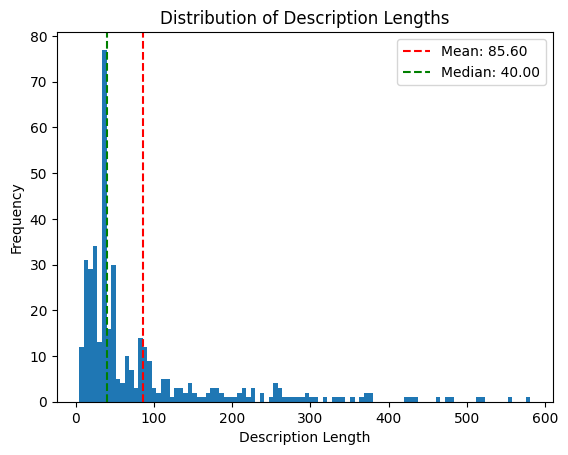

In [4]:
import matplotlib.pyplot as plt

plt.hist(df["length"], bins=100)

mean = df["length"].mean()
median = df["length"].median()

plt.axvline(mean, color='red', linestyle='--')
plt.axvline(median, color='green', linestyle='--')

plt.xlabel("Description Length")
plt.ylabel("Frequency")
plt.title("Distribution of Description Lengths")

plt.legend([f"Mean: {mean:.2f}", f"Median: {median:.2f}"])

plt.show()

In [5]:
# display text with smallest length
df[df["length"] == df["length"].min()]["description"]


50                               Wie warm ist das Wasser
288    die TMO-Gruppenmatrix der Polizei Rheinland-Pf...
Name: description, dtype: object

In [19]:
docs = df["description"].tolist()
docs = [doc[:512] for doc in df["description"].tolist()]

model_name = "aari1995/German_Semantic_STS_V2"
max_length = 512

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cpu")
feature_extraction_pipeline = pipeline("feature-extraction", model=model, tokenizer=tokenizer, device=device, max_length=max_length)

embeddings = []

with tqdm(total=len(docs), ncols=80, desc="Calculating embeddings") as pbar:
    for doc in docs:
        encoding = tokenizer(doc, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        embedding = feature_extraction_pipeline(inputs=encoding, attention_mask=attention_mask)[0]
        embeddings.append(embedding)
        pbar.update(1)

embeddings = np.stack(embeddings)

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs, embeddings)

Calculating embeddings:   0%|                           | 0/399 [00:00<?, ?it/s]


ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
embedding_shapes = [np.array(embedding).shape for embedding in embeddings]
print(embedding_shapes)

[(129, 1024), (50, 1024), (129, 1024), (86, 1024), (122, 1024), (67, 1024), (91, 1024), (76, 1024), (30, 1024), (72, 1024), (60, 1024), (100, 1024), (125, 1024), (116, 1024), (115, 1024), (109, 1024), (118, 1024), (72, 1024), (44, 1024), (86, 1024), (105, 1024), (113, 1024), (105, 1024), (138, 1024), (41, 1024), (51, 1024), (29, 1024), (113, 1024), (43, 1024), (35, 1024), (62, 1024), (42, 1024), (46, 1024), (86, 1024), (86, 1024), (93, 1024), (103, 1024), (25, 1024), (42, 1024), (68, 1024), (48, 1024), (11, 1024), (65, 1024), (112, 1024), (80, 1024), (56, 1024), (108, 1024), (86, 1024), (65, 1024), (129, 1024), (7, 1024), (105, 1024), (62, 1024), (93, 1024), (109, 1024), (21, 1024), (95, 1024), (145, 1024), (95, 1024), (118, 1024), (47, 1024), (102, 1024), (61, 1024), (23, 1024), (108, 1024), (86, 1024), (49, 1024), (104, 1024), (53, 1024), (114, 1024), (91, 1024), (101, 1024), (109, 1024), (96, 1024), (47, 1024), (86, 1024), (105, 1024), (63, 1024), (62, 1024), (68, 1024), (113, 1024)

In [ ]:

prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?"

generator = pipeline('text2text-generation', model='google/flan-t5-base')
representation_model = TextGeneration(generator)

topic_model = BERTopic(epresentation_model=representation_model)

topics, probs = topic_model.fit_transform(docs, embeddings)

KeyboardInterrupt: 

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5,-1_de_tunesien_https_www,"[de, tunesien, https, www, das, der, frankfurt...",[den Vergleichsvertrag zwischen der Stadt Fran...
1,0,227,0_die_der_im_des,"[die, der, im, des, und, in, ja, an, letzten, ...",[1. Wann haben die beiden letzten lebensmittel...
2,1,79,1_die_und_sie_der,"[die, und, sie, der, ich, zu, bitte, nach, des...",[Guten Tag!\r\n\r\nIch bitte Sie im Rahmen des...
3,2,47,2_die_der_für_und,"[die, der, für, und, in, wie, eine, ich, nach,...",[1) eine Übersicht (möglichst tabellarisch) mi...
4,3,25,3_the_fragdenstaat_https_and,"[the, fragdenstaat, https, and, de, or, of, in...","[Die Aufgaben, Erwartungshorizonte und Lösunge..."
5,4,16,4_auflistung_jeweils_für_gesetzeskommentare,"[auflistung, jeweils, für, gesetzeskommentare,...",[Eine Auflistung der Ausgaben des Gerichts im ...
